# Árboles de decisión

Francisco Jesús Martín Mateos <br>
Miguel A. Gutiérrez Naranjo

Última actualización: 14 de Noviembre, 2023

En esta sesión de trabajo con Jupyter veremos la implementación en scikit-learm de los árboles de decisión y aplicaremos los conceptos al conjunto de datos Iris. Scikit-learn es un conjunto de librerías python para el Aprendizaje Automático. Puede encontrarse en la [web de scikit learn](https://scikit-learn.org/stable/) y viene en la instalación base de [Anaconda](https://www.anaconda.com/).

Usaremos las siguientes librerías:
* [Scikit-learn](https://scikit-learn.org/stable/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)

Además, usaremos la librería [Time](https://docs.python.org/3/library/time.html) y el programa [Graphviz](https://www.graphviz.org/) para trabajar con imágenes en formato 'dot'.

In [1]:
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn import metrics as skm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Para evitar avisos innecesarios (FutureWarnings):
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Un ejemplo de juguete

Vamos a empezar con un ejemplo de juguete para familiarizarnos con el entorno. Supongamos que tenemos el siguiente conjunto de entrenamiento con dos atributos _Temperatura_ y _Humedad_ y dos valores de clasificación 0 y 1

| Temperatura | Humedad | Clasificación
| ------------|---------|--------------
| 28  | 24 | 1 
| 30  | 26 | 1 
| 32  | 24 | 0 
| 34  | 26 | 0 

Guardamos las instancias y los valores de clasificación en dos matrices _(arrays)_ con numpy

In [3]:
X_toy_data = np.array([[28,24],
                       [30,26],
                       [32,24],
                       [34,26]],dtype='float32')

y_toy_data = np.array([1,1,0,0],dtype='int8')

Puesto que las instancias son pares de números, podemos representarlas como puntos del plano con la ayuda de la librería [Matplotlib](https://matplotlib.org/)

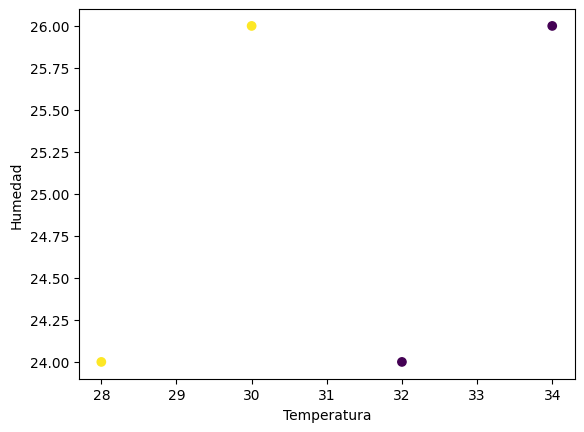

In [4]:
plt.scatter(X_toy_data[:,0],X_toy_data[:,1],c=y_toy_data)
plt.xlabel("Temperatura")
plt.ylabel("Humedad")
plt.show()

Visualizar los datos a veces ayuda. En este caso vemos que separando *Temperatura* representado en el eje horizontal con un punto de corte entre 30 y 32 será suficiente para separar las clases.

A continuación creamos el árbol de decisión. El algoritmo de aprendizaje de árboles de decisión que está incluido en *scikit_learn* es [CART](https://books.google.es/books/about/Classification_and_regression_trees.html?id=uxPvAAAAMAAJ&redir_esc=y), que fue introducido por Leo Breiman en 1984.

Al igual que otros modelos de clasificación, está implementado en scikit learn como una clase, [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), de la librería [`tree`](http://scikit-learn.org/stable/modules/tree.html). Puesto que ya hemos importado esa clase, creamos una instancia que llamaremos 'model_toy'.  Creamos un árbol *abstracto*. esto es, fijamos los parámetros que vamos a usar pero no lo asociamos de momento a ningún conjunto de entrenamiento. En esta primera aproximación, no modificamos los parámetros y usamos los que trae por defecto la implementación.

In [5]:
model_toy = DecisionTreeClassifier()

Como otros modelos de clasificación en *scikit_learn*, la clase `DecisionTreeClassifier` dispone de un método para entrenar el modelo `fit` al que hay que pasar el conjunto de entrenamiento con dos argumentos: un array con el conjunto de datos y otro con el valor de clasificación para esos datos.

In [6]:
model_toy.fit(X_toy_data,y_toy_data)

DecisionTreeClassifier()

El árbol se puede configurar mediante muchos parámetros que se pueden fijar. Como no hemos cambiado ninguno, realizamos el entrenamiento con los parámetros fijados por defecto. Puedes verlos en [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Una vez entrenado el clasificador, podemos ver el árbol construido en modo texto. Para ello usamos *export_text* donde introducimos los nombres de los atributos *Temperatura* y *Humedad*.

In [7]:
model_toy_text = export_text(model_toy, feature_names=['Temperatura','Humedad'])
print(model_toy_text)

|--- Temperatura <= 31.00
|   |--- class: 1
|--- Temperatura >  31.00
|   |--- class: 0



Como cabía esperar, el atributo _Temperatura_ basta para clasificar correctamente los ejemplos. En este caso, el punto de corte 31 discrimina entre los valores de clasificación 0 y 1. 

Vamos a usar ese árbol para hacer predicciones. Supongamos que tenemos tres nuevas instancias (33,27), (30,20) y (34,24) para las que queremos conocer la clasificación. Las guardamos en una matriz.

In [8]:
X_toy_nuevo = np.array([[33,27],
                        [30,20],
                        [34,24]])

Hacemos la predicción según el árbol

In [9]:
pred_toy = model_toy.predict(X_toy_nuevo)
print("Predicción: {}".format(pred_toy))

Predicción: [0 1 0]


Tal como cabía esperar, la clasificación del primer y tercer ejemplo es 0 ya que el valor de *Temperatura* en esos ejemplos es mayor que 31.

A continuación vamos a realizar un experimento con datos reales.

## Procesado de los datos

En primer lugar, vamos a familiarizarnos con el conjunto de datos [Iris](https://es.wikipedia.org/wiki/Iris_flor_conjunto_de_datos) que vamos a utilizar. Contiene información de tres especies de la flor Iris: Iris setosa, Iris virginica e Iris versicolor. En este conjunto de datos hay información de 150 muestras de flores, 50 de cada tipo, sobre el largo y el ancho del pétalo y el sépalo, medidos en centímetros.

<img src="flor-de-iris.jpg">

Cargamos el conjunto de datos Iris incluido en Scikit-learn, usando la función [`load_iris()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) de la biblioteca [`sklearn.datasets`](https://scikit-learn.org/stable/datasets/index.html)

In [3]:
iris_dataset = load_iris()

El objeto "iris_dataset" es un objeto de tipo [Bunch](https://stackoverflow.com/questions/56286221/what-is-the-difference-between-bunch-and-dictionary-type-in-python) 
que es como un diccionario, pero admite atributos. Su estructura es la de pares claves-valores. Podemos ver las claves (tipo de datos) que se guarda en el *iris dataset* de scikit learn. 

In [4]:
print("Claves: {}".format(iris_dataset.keys()))

Claves: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


'DESCR' es una descripción del dataset. Vemos el principo de esa descripción.

In [13]:
print(iris_dataset['DESCR'][:] + "\n...")

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

'data' contiene las instancias

In [14]:
print("Datos de clasificación:\n {}".format(iris_dataset['data']))

Datos de clasificación:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 

'target' contiene los valores de clasificación (en este caso, 0,1,2), 'target_names' los nombres de los valores de clasificación ('setosa', 'versicolor' o 'virgínica') y 'feature_names' los nombres de los atributos.

In [15]:
print("Valores de clasificación:\n {}".format(iris_dataset['target']))
print("Nombres de los valores de clasificación: {}".format(iris_dataset['target_names']))
print("Atributos: {}".format(iris_dataset['feature_names']))

Valores de clasificación:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Nombres de los valores de clasificación: ['setosa' 'versicolor' 'virginica']
Atributos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Tanto las instancias como los valores de clasificación están almacenados en *arrays*.

In [16]:
iris_dataset.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [17]:
iris_dataset.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Guardamos los campos que nos resultan de interés en las siguientes variables.

In [11]:
X_data, y_data, X_names, y_names = \
    iris_dataset.data, iris_dataset.target, iris_dataset.feature_names, iris_dataset.target_names
print(type(y_names))

<class 'numpy.ndarray'>


Al igual que con el primer ejemplo, vamos a intentar tener una idea preliminar sobre cómo se distribuyen los datos. En este caso es más difícil porque las instancias tienen cuatro valores numéricos, esto es, son puntos en ${\mathbb R}^4$.

Vamos a visualizar cómo se distribuyen estos datos y para ello usamos las librerías 
['matplotlib'](https://matplotlib.org/) y ['pandas'](https://pandas.pydata.org/). En primer lugar, creamos un _dataframe_ de pandas a partir del conjunto de instancias.

In [19]:
iris_dataframe = pd.DataFrame(X_data, columns=iris_dataset.feature_names)

Podemos ver las primeras filas del _dataframe_

In [20]:
iris_dataframe[:10]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


Esta representación nos permite ver las matrices de forma parecida a una hoja Excel, pero lo importante ahora es que podemos representar gráficamente las columnas tomadas de dos en dos para poder visualizar el conjunto. Lo hacemos con el método 'scatter_matrix' de [pandas](https://pandas.pydata.org/). El mapa de color por defecto es [_viridis_ ](https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html) y lo asociamos a los valores del clasificación *y_data*. El color morado corresponde al valor 'setosa' (0), el celeste al valor 'versicolor' (1) y el color amarillo corresponde a 'virginica' (2).

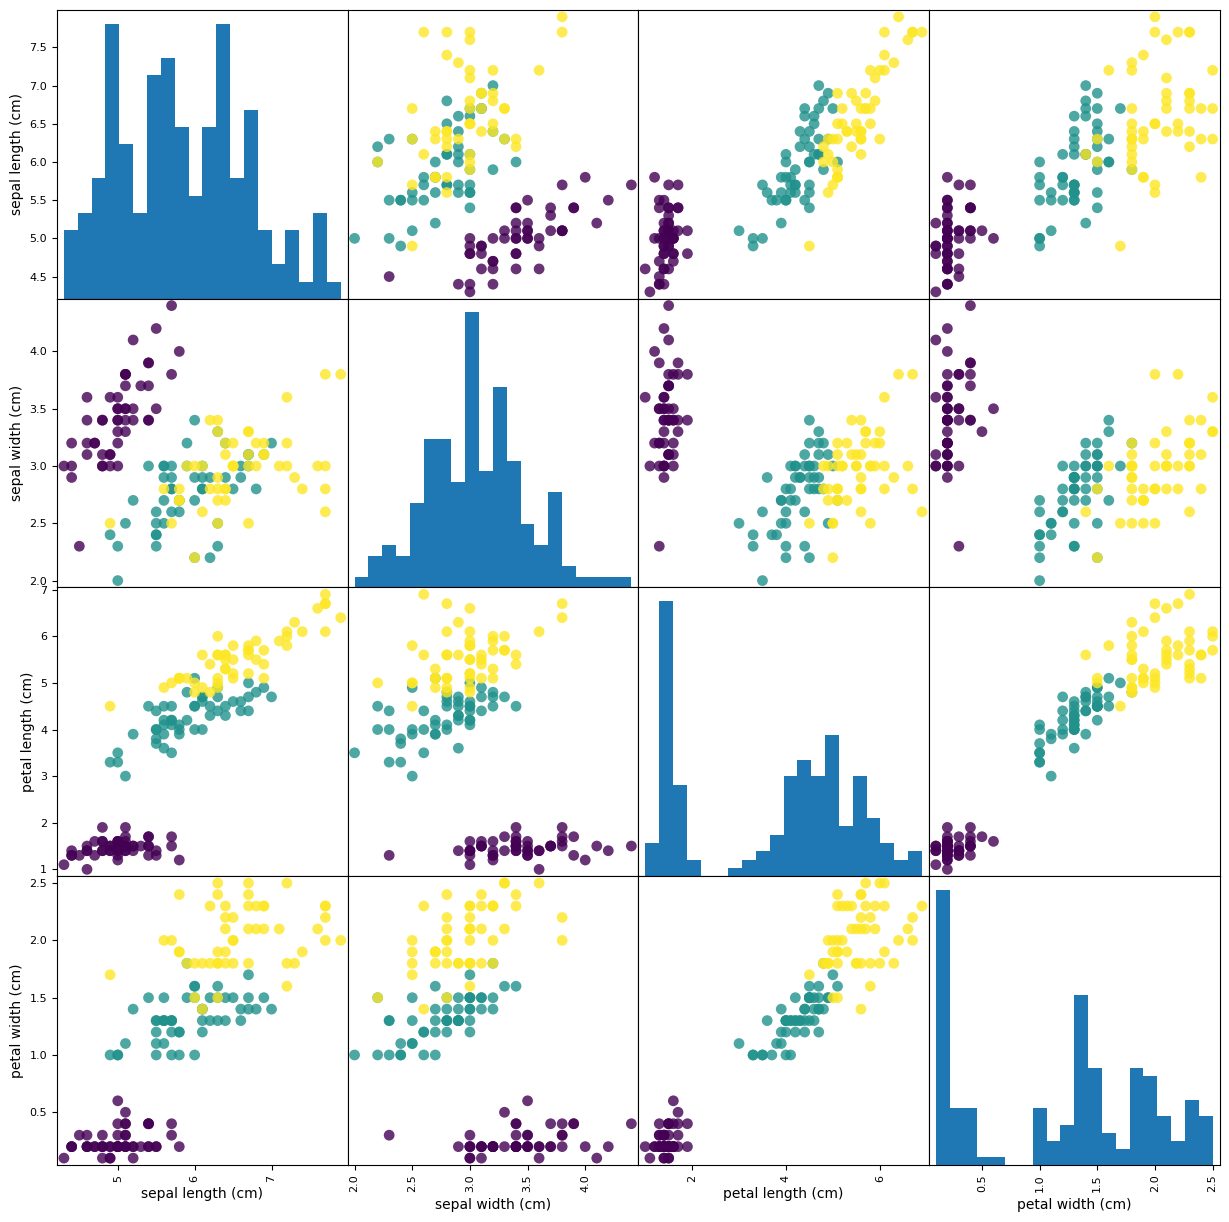

In [21]:
sp = pd.plotting.scatter_matrix(iris_dataframe, c=y_data, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

Con esta matriz de visualización ya vemos que el grupo "setosa" (con etiqueta 0 y color morado) se va a poder diferenciar fácilmente de los otros dos y que la longitud del pétalo (por ejemplo) va a ser suficiente para discriminar este grupo del resto.

En esta primera aproximación exploratoria, otra cosa que podemos hacer en este primer análisis es estudiar el [coeficiente de correlación de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) entre los atributos. De este modo podemos tener una estimación sobre cómo están relacionadas dos variables.

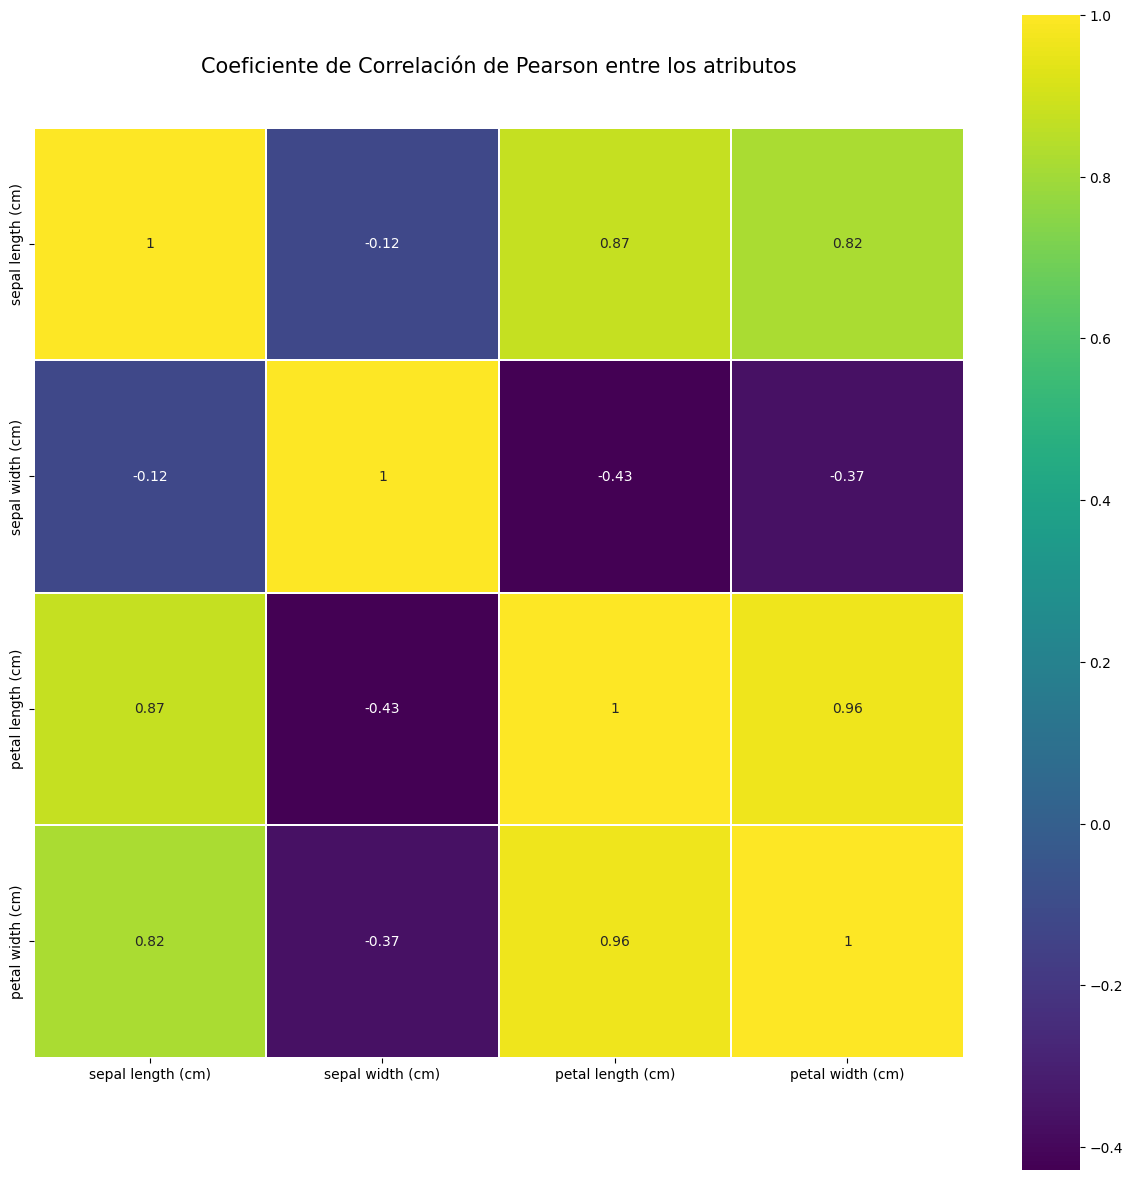

In [22]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(iris_dataframe.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.show()

Como se puede ver, el coeficiente refleja una fuerte correlación entre la longitud y anchura del pétalo, pero esto ya lo sabíamos a partir del 'scatter_matrix' que hemos hecho antes.

Podemos verlo con más detalle mediante regresión lineal.

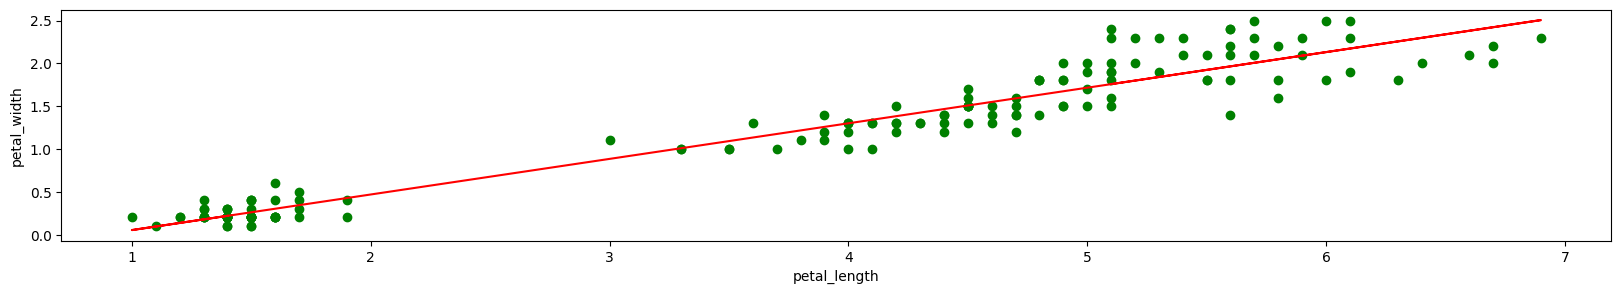

In [23]:
plt.rcParams["figure.figsize"] = (20,3)

petal_length = iris_dataset.data[:,2].reshape(-1,1)
petal_width = iris_dataset.data[:,3]

model_lineal = linear_model.LinearRegression()
model_lineal.fit(petal_length,petal_width)

y_model_lineal_pred = model_lineal.predict(petal_length)

plt.scatter(petal_length, petal_width,color='green')
plt.plot(petal_length, y_model_lineal_pred, color='red')
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.show()

## Árboles de decisión

Después de este breve análisis preliminar para familiarizarnos con los datos, pasamos a su estudio con árboles de decisión. Creamos una nueva instancia de la clase [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) y la llamamos _model_.

In [24]:
model = DecisionTreeClassifier()

Entrenamos el modelo con los datos de la flor iris.

In [25]:
model.fit(X_data,y_data)

DecisionTreeClassifier()

Al igual que antes, entrenamos el árbol con los valores por defecto. Estos valores servirán para ajustar el proceso de aprendizaje y los veremos más adelante. Veamos ahora el aspecto que tiene el árbol de decisión aprendido. 

In [26]:
model_text = export_text(model, feature_names=iris_dataset['feature_names'])
print(model_text)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- sepal length (cm) <= 6.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sepal length (cm) >  6.95
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



En este caso, la representación en modo texto es poco intuitiva y es mejor usar una representación gráfica. Para ello vamos a usar el método [`export_graphviz`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) de la librería `tree`. Este método genera una descripción del árbol de decisión en el formato `dot` del software de visualización de grafos [`graphviz`](https://www.graphviz.org/). En la llamada de este método pasamos como argumento el modelo de clasificación entrenado, el fichero en el que queremos almacenar el resultado (con la extensión `dot`) y otras opciones como el array de nombres de las características y detalles relacionados con la representación gráfica.

In [27]:
export_graphviz(
    model,
    out_file="gini_1.dot",
    feature_names=iris_dataset.feature_names,
    rounded=True,
    filled=True)

La orden anterior ha creado un fichero en formato _dot_ que es el propio del programa _graphviz_. Puedes ver el contenido del fichero con un editor de textos y puedes crear un fichero _png_ a partir de él mediante la siguiente instrucción por línea de comando (es necesario tener instalado [`graphviz`](https://www.graphviz.org/download/))
:
* dot -Tpng gini_1.dot -o gini_1.png

También podemos hacerlo desde aquí

In [28]:
!dot -Tpng gini_1.dot -o gini_1.png

La ejecución del comando 'dot' ha generado un fichero en el directorio donde tenemos este notebook. Para ver el árbol de decisión generado, lo incluimos como una imagen externa en la paleta de dibujo de `matplotlib`:

<Figure size 2000x300 with 0 Axes>

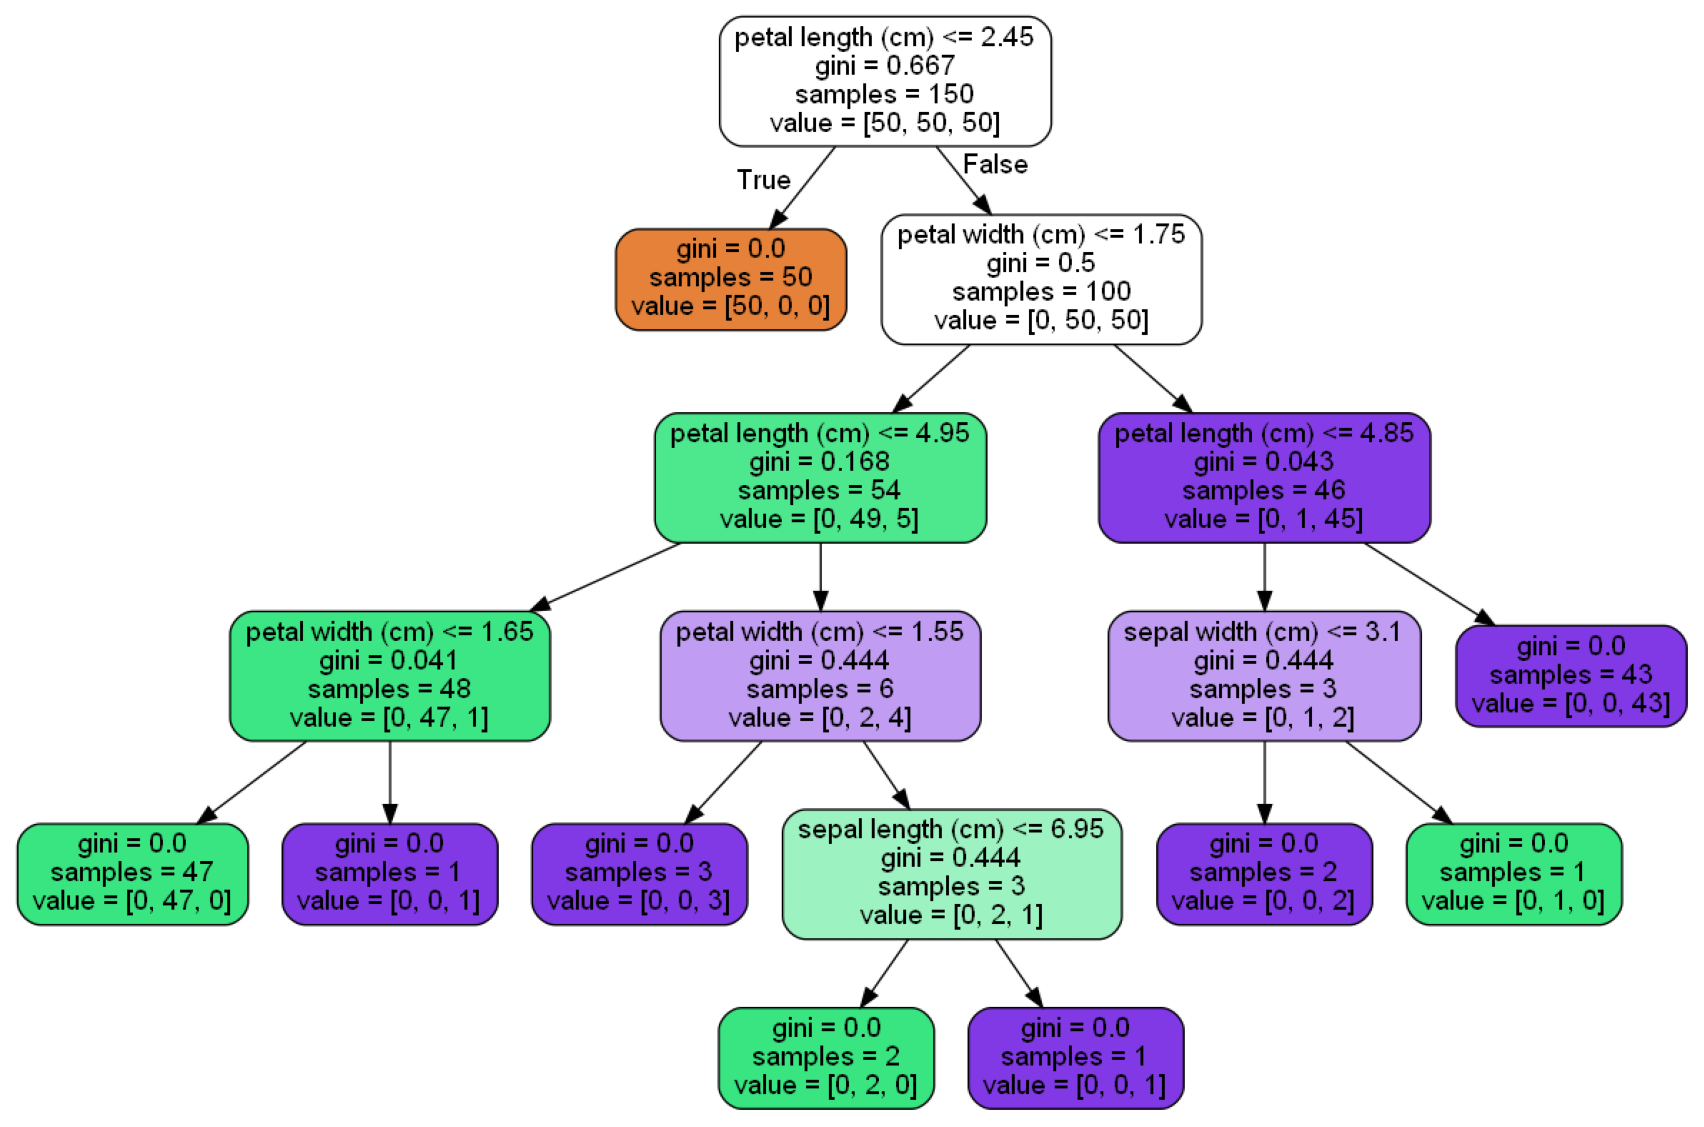

In [29]:
plt.clf()
image = plt.imread("gini_1.png")
height, width, depth = image.shape
dpi = 70
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
plt.axis('off')
plt.imshow(image)
plt.show()

También podemos visualizar un fichero árbol de decisión desde python sin necesidad de crear un fichero externo.

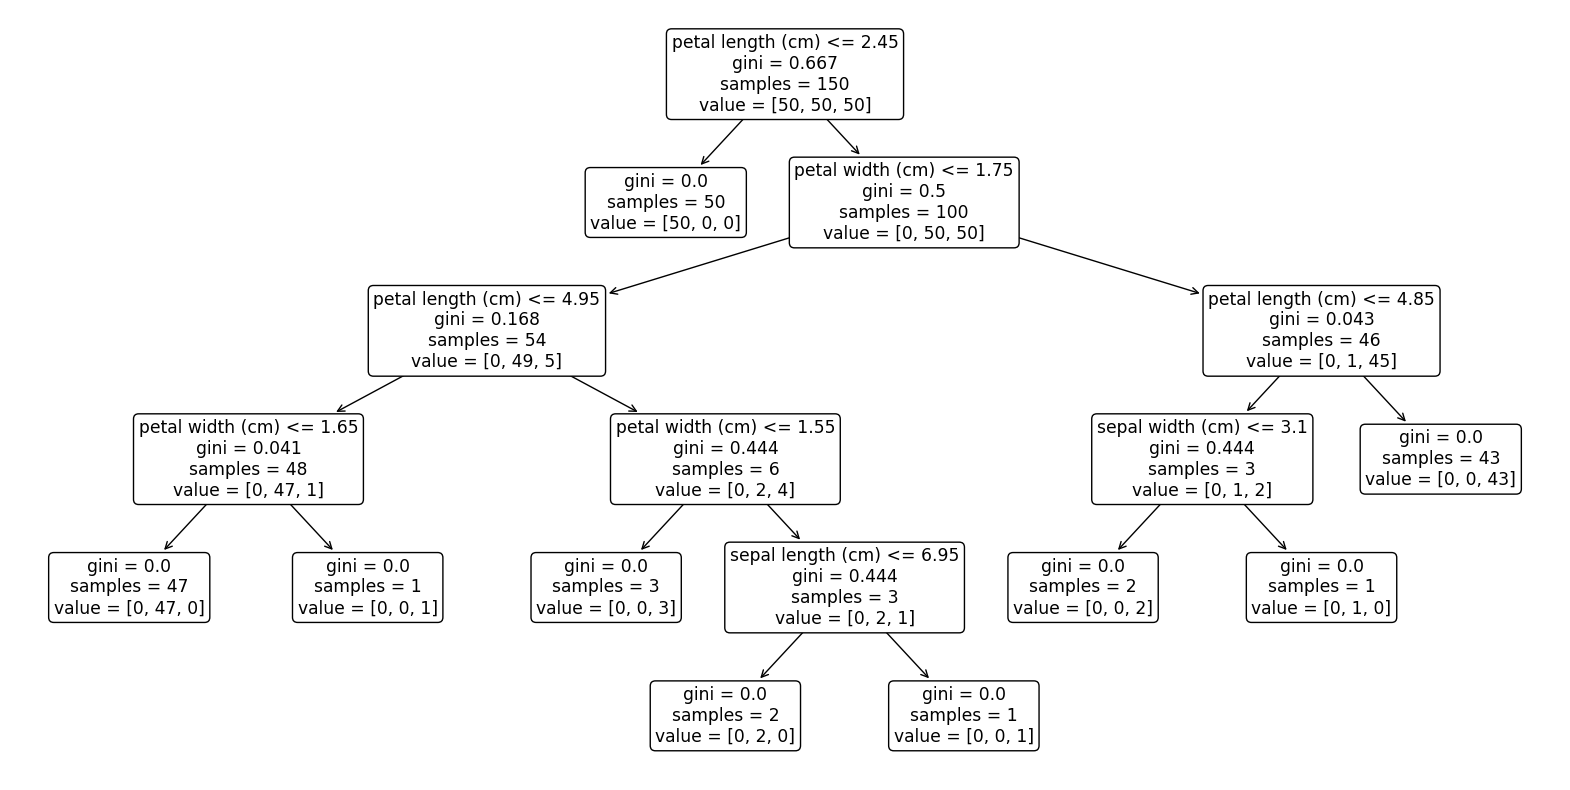

In [30]:
plt.rcParams["figure.figsize"] = (20,10)
plot_tree(model,rounded=True,feature_names=iris_dataset.feature_names)
plt.show()

Cada nodo interno del árbol anterior muestra información sobre el criterio de separación elegido, el valor del grado de dispersión o impureza para dicho nodo, el número de ejemplos del conjunto de entrenamiento asociados a ese nodo y la distribución de los valores de clasificación para dichos ejemplos. 

Por ejemplo, el nodo inicial nos indica que el primer criterio de separación elegido consiste en comprobar si la longitud del pétalo es menor o igual que `2.45` centímetros. Eso quiere decir que éste es el criterio de separación que mejor clasifica los datos iniciales. El conjunto de datos inicial, que está asociado a este nodo, tiene un grado de dispersión (en este caso el índice de Gini) de `0.667`, está formado por `150` muestras (todas las del conjunto de entrenamiento) y su distribución en los tres valores de clasificación es `[50,50,50]`. El valor del índice de Gini para este nodo se puede confirmar con esta información:

$$G({\cal S}) = 1 - \sum_{j=1}^k {p_j}^2 = 1 - \sum_{j=1}^3 (\frac{1}{3})^2 = 1 - \frac{3}{9} = \frac{2}{3} \approx 0.667$$

Como se puede observar del resultado del primer criterio de separación, hay un total de `50` muestras cuyo valor de anchura de pétalo es menor o igual que `2.45` y otras `100` que están por encima. El conjunto de muestras asociado a la rama de la izquierda tiene un índice de Gini de `0` pues todas son del tipo Iris setosa. Por tanto, el nodo de la izquierda es un nodo hoja que tiene asociado el valor de clasificación "Iris setosa". Su color está asociado con ese valor de clasificación.

Por otro lado, hay un total de `100` muestras cuyo valor de anchura de pétalo es mayor que `2.45`. Estas son las muestras asociadas al siguiente nodo de la rama de la derecha. La distribución de los valores de clasificación en este conjunto es `[0,50,50]`, de aquí que su grado de impureza sea `0.5`. De nuevo, este dato se puede confirmar con los datos disponibles usando la fórmula del índice de Gini.

Dado que en este nodo las muestras no están correctamente clasificadas, hay que buscar otro criterio de separación. En este caso consiste en comprobar si la anchura del pétalo es menor o igual que `1.75` centímetros. En este caso el conjunto de datos (las `100` muestras de Iris virgínica e Iris versicolor), queda dividido en dos subconjuntos. El de la izquierda está formado por `54` muestras (`49` de la clase Iris versicolor y `5` de la clase Iris virgínica), con un índice de impureza de `0.168`. El de la derecha está formado por `46` muestras (`1` de la clase Iris versicolor y `45` de la clase Iris virgínica), con un índice de impureza de `0.043`.

Como hemos visto el grado de dispersión se ha calculado usando el índice de Gini. Este es el valor por defecto del algoritmo de aprendizaje de árboles de decisión en *scikit_learn*. Podemos cambiar este criterio usando el parámetro `criterion` del constructor de la clase `DecisionTreeClassifier`. Los valores disponibles son `gini` para usar el índice de Gini y `entropy` para usar la ganancia de información. Veamos como queda el árbol de decisión construido usando la ganancia de información:

In [31]:
model_entr = DecisionTreeClassifier(criterion='entropy')

model_entr.fit(X_data,y_data)

DecisionTreeClassifier(criterion='entropy')

Si visualizamos este árbol de decisión, observaremos que es muy parecido

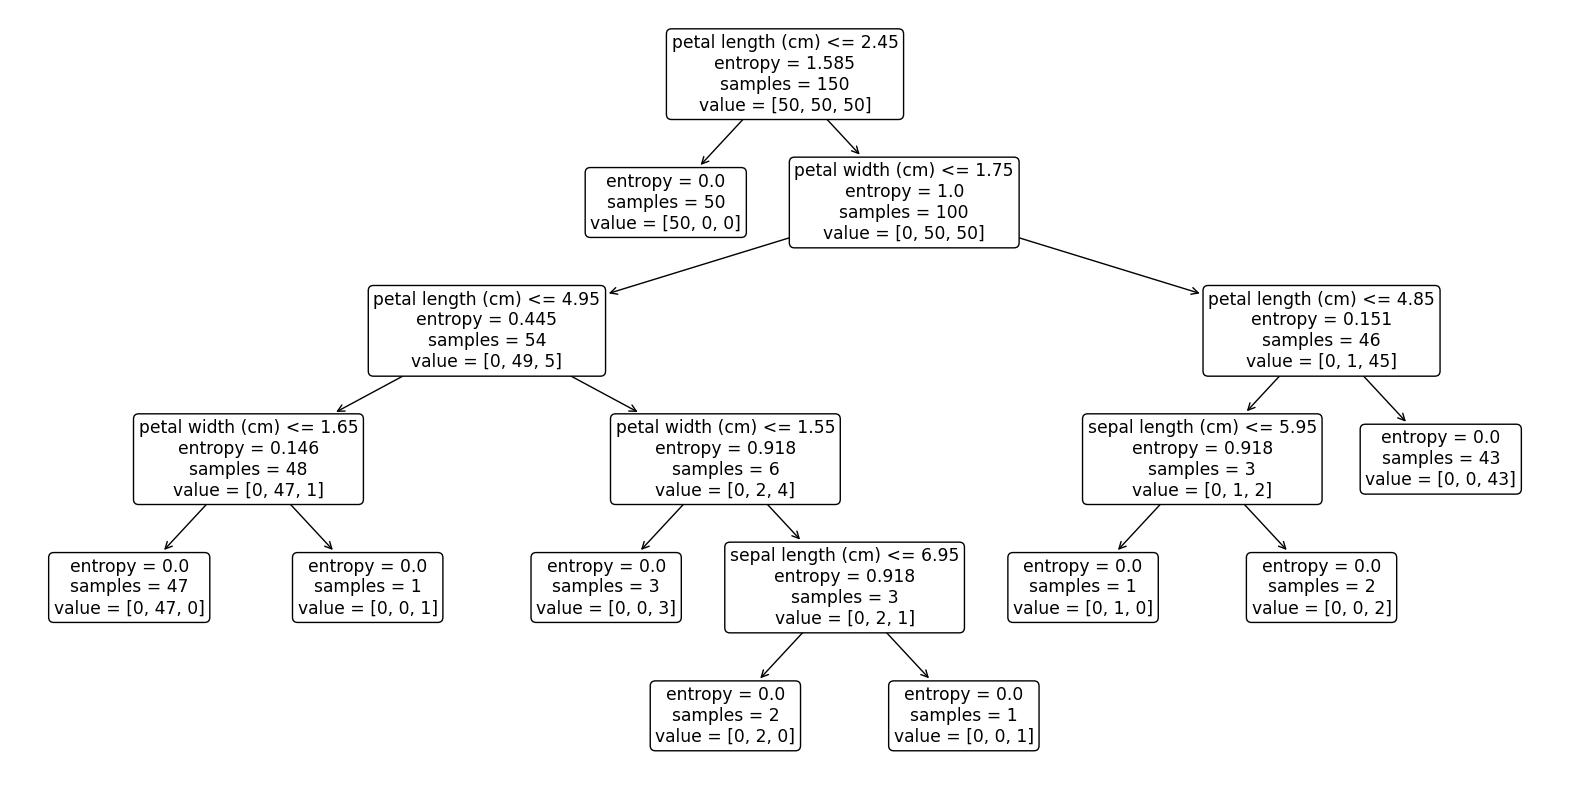

In [32]:
plot_tree(model_entr,rounded=True,feature_names=iris_dataset.feature_names)
plt.show()

Nuestro método para escoger el mejor criterio de separación no siempre obtiene el mismo resultado que el que viene implementado en *scikit_learn*. Esta circunstancia es así puesto que el algoritmo implementado en *scikit_learn* toma decisiones aleatorias en algunos casos.

## Sobreajuste

Veamos ahora como tratar el sobreajuste en los árboles de decisión. Si analizamos los árboles obtenidos anteriormente veremos que a partir de la segunda capa los criterios de separación buscan distinguir una cantidad muy pequeña de muestras. De hecho, en la rama de la derecha hay un desarrollo considerable (dos nodos internos) para distinguir una única muestra entre las demás. Esta es una característica habitual en los árboles de decisión sobreajustados. El problema del sobreajuste se corresponde con un bajo rendimiento del modelo aprendido en conjuntos de datos independientes del conjunto de entrenamiento.

Para apreciar cómo disminuye el sobreajuste del árbol de decisión aprendido será necesario considerar previamente dos conjuntos independientes de muestras: un conjunto de entrenamiento para construir el modelo y un conjunto de prueba para evaluarlo.

Para hacer esto usamos la función `train_test_split` de la librería `model_selection` incluida en *scikit_learn*. Esta función reparte los ejemplos en los conjuntos de entrenamiento y prueba aleatoriamente. En este caso consideramos un conjunto de prueba con el 25% de los datos originales y un conjunto de entrenamiento con el 75% restante. Para apreciar las mejoras obtenidas con las distintas estrategias de reducción de sobreajuste, fijamos la semilla del generador de números aleatorios usado para realizar este reparto.

In [33]:
X_train, X_test, y_train, y_test = \
  train_test_split(X_data,y_data,test_size = 0.25,random_state=462)

In [34]:
len(y_test)

38

En el siguiente gráfico vemos de forma conjunta las representaciones de las dos primeras características del conjunto de datos inicial, el conjunto de entrenamiento y el conjunto de prueba.

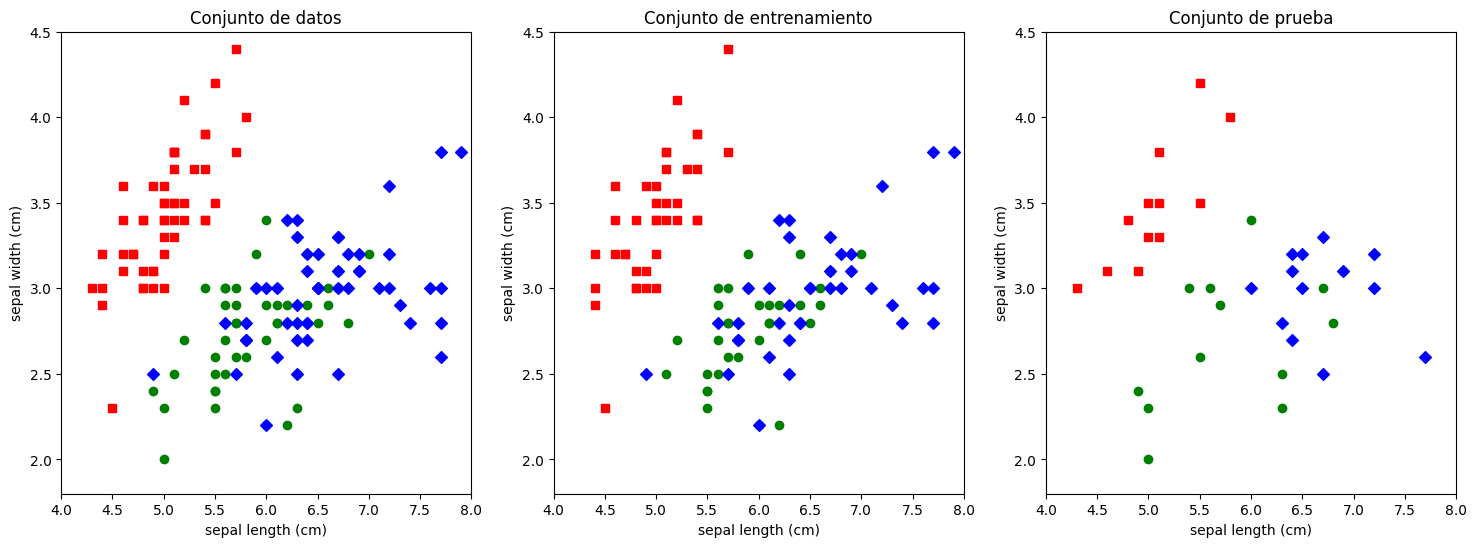

In [35]:
def representacion_grafica(datos,caracteristicas,objetivo,clases,c1,c2):
    for tipo,marca,color in zip(range(len(clases)),"soD","rgb"):
        plt.scatter(datos[objetivo == tipo,c1],
                    datos[objetivo == tipo,c2],marker=marca,c=color)
    plt.xlabel(caracteristicas[c1])
    plt.ylabel(caracteristicas[c2])


plt.rcParams["figure.figsize"] = [18,6]
plt.clf()
splt = plt.subplot(131)
splt.set_xlim(4,8)
splt.set_ylim(1.8,4.5)
splt.set_title("Conjunto de datos")
representacion_grafica(X_data,X_names,y_data,y_names,0,1)
splt = plt.subplot(132)
splt.set_xlim(4,8)
splt.set_ylim(1.8,4.5)
splt.set_title("Conjunto de entrenamiento")
representacion_grafica(X_train,X_names,y_train,y_names,0,1)
splt = plt.subplot(133)
splt.set_xlim(4,8)
splt.set_ylim(1.8,4.5)
splt.set_title("Conjunto de prueba")
representacion_grafica(X_test,X_names,y_test,y_names,0,1)
plt.show()

Ahora construimos un árbol de decisión con el conjunto de entrenamiento tal y como hemos hecho anteriormente. En este caso también fijamos el valor de la semilla del generador de números aleatorios.

In [36]:
tree3_clf = DecisionTreeClassifier(random_state=10)

tree3_clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

La representación gráfica del árbol obtenido es la siguiente:

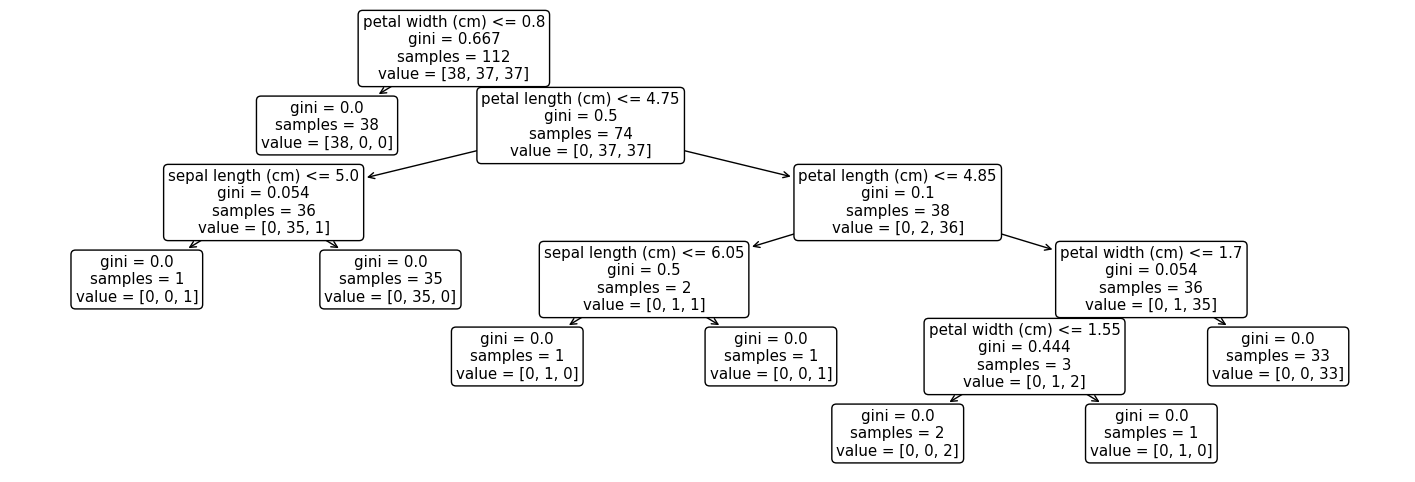

In [37]:
plot_tree(tree3_clf,rounded=True,feature_names=iris_dataset.feature_names)
plt.show()

Al igual que ocurría con el conjunto de datos original, el árbol obtenido tiene ramificaciones para distinguir conjuntos muy pequeños de datos. Veamos su rendimiento en el conjunto de prueba, para esto usamos el método `predict` del modelo obtenido:

In [38]:
pred3 = tree3_clf.predict(X_test)
pred3

array([0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 0, 0, 2,
       1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 2])

Si comparamos estos resultados con los valores de clasificación reales en el conjunto de prueba, apreciamos varias diferencias:

In [39]:
y_test

array([0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 0, 0, 2,
       1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 2, 0, 1])

Podemos calcular la *Medida de Rendimiento* como proporción de aciertos sobre el conjunto de test

In [40]:
sum(x1==x2 for x1,x2 in zip(pred3,y_test))/len(y_test)

0.7631578947368421

Scikit learn ya trae implementada esa medida de rendimiento como función *score*. A continuación calculamos el rendimiento de este modelo en el conjunto de entrenamiento, el conjunto de prueba y el conjunto de datos inicial.

In [41]:
print("Rendimiento en el conjunto de entrenamiento: ",tree3_clf.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",tree3_clf.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",tree3_clf.score(X_data,y_data))

Rendimiento en el conjunto de entrenamiento:  1.0
Rendimiento en el conjunto de prueba:  0.7631578947368421
Rendimiento en el conjunto total:  0.94


Como era de esperar, comprobamos que la medida de rendimiento sobre el conjunto de entrenamiento es 1.0

También podemos ver las matrices de confusión

In [42]:
print('### Matrices de confusión ###\n')
print('Entrenamiento:')
print(skm.confusion_matrix(y_train, tree3_clf.predict(X_train)))
print('\nPruebas:')
print(skm.confusion_matrix(y_test, tree3_clf.predict(X_test)))

### Matrices de confusión ###

Entrenamiento:
[[38  0  0]
 [ 0 37  0]
 [ 0  0 37]]

Pruebas:
[[12  0  0]
 [ 0  6  7]
 [ 0  2 11]]


También podemos representar gráficamente la matriz de confusión. En este caso la vemos sobre el conjunto de test.

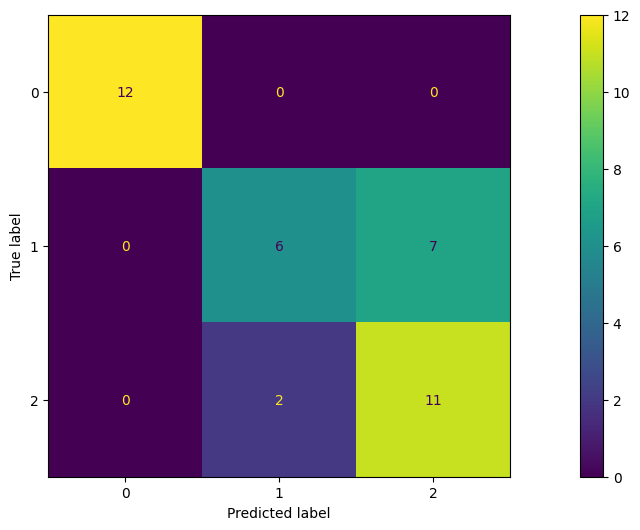

In [50]:
cm = skm.confusion_matrix(y_test, pred3, labels=tree3_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree3_clf.classes_)
disp.plot()
plt.show()

También podemos usar Validación Cruzada con estratificación para obtener una medida de rendimiento del árbol.
En este caso dividimos el conjunto en K=10 conjuntos y realizamos 10 entrenamientos dejando fuera cada vez uno de esos 10 conjuntos.

In [51]:
# Versión nueva
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 357 )
scores = cross_val_score(tree3_clf, X_train, y_train, 
                                 scoring = "accuracy", cv = cross_validation, n_jobs = 1 )
scores

array([1.        , 1.        , 1.        , 1.        , 0.81818182,
       0.81818182, 1.        , 0.90909091, 1.        , 0.90909091])

"scores" nos devuelve el rendimienso *(accuracy)* de los 10 árboles obtenidos al quitar el 10% en cada una de las iteraciones. Es más interesante conocer la media y la desviación típica de esos rendimientos.

In [52]:
scores.mean()

0.9454545454545455

In [53]:
scores.std()

0.07272727272727272

In [54]:
# Rendimiento con 5 cifras decimales (Valor medio y desviación típica)
print( "Rendimiento: Valor medio %0.5f y desviación típica %0.5f)" % (scores.mean(), scores.std()))

Rendimiento: Valor medio 0.94545 y desviación típica 0.07273)


La creación del árbol está sujeta a la elección de diversos parámetros. Podemos estudiar también cómo afecta al resultado el cambio de algunos de esos parámetros. Por ejemplo, podemos tomar el *min_samples_split* que es el número mínimo de ejemplos requerido para que un nodo interno se divida. Si el nodo tiene menos ejemplos, la rama se detiene ahí.

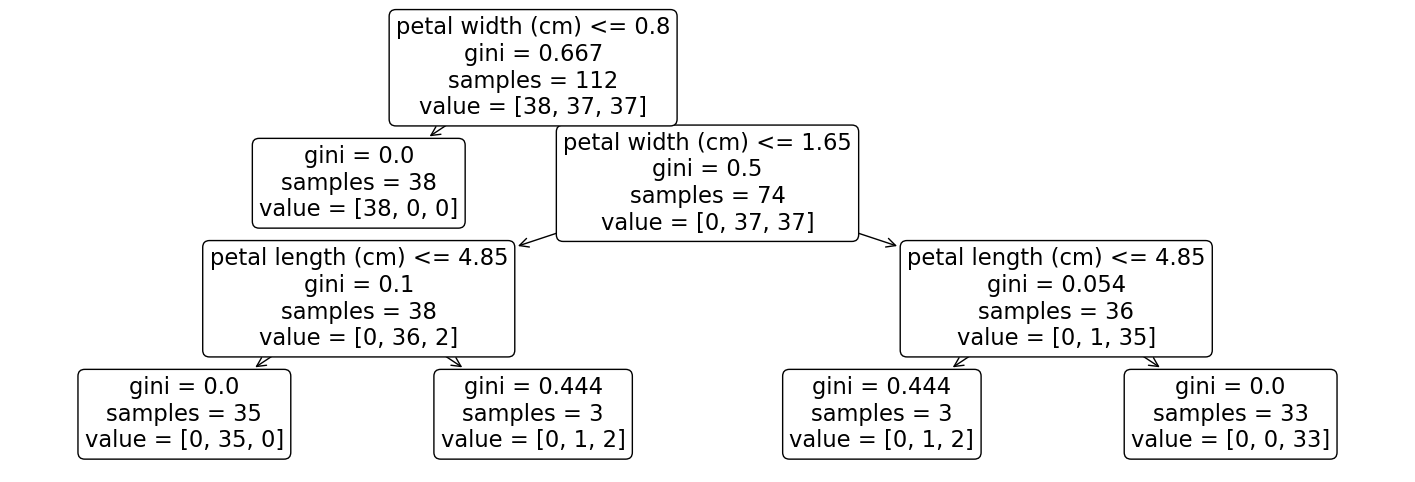

Rendimiento en el conjunto de entrenamiento:  0.9821428571428571
Rendimiento en el conjunto de prueba:  0.9210526315789473
Rendimiento en el conjunto total:  0.9666666666666667


In [55]:
mi_min_samples = 5

tree_aux_min_samples = DecisionTreeClassifier(min_samples_split=mi_min_samples)
tree_aux_min_samples.fit(X_train, y_train)

plot_tree(tree_aux_min_samples,rounded=True,feature_names=iris_dataset.feature_names)
plt.show()

print("Rendimiento en el conjunto de entrenamiento: ",tree_aux_min_samples.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",tree_aux_min_samples.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",tree_aux_min_samples.score(X_data,y_data))

Vemos que el rendimiento sobre el conjunto de entrenamiento ya no es 1, pero el rendimiento sobre el conjunto de test ha subido. 
 
En este ejemplo, el parámetro *min_samples* lo hemos elegido nosotros. ¿Podemos estar seguros de que esa elección es la mejor? Veamos  cómo cambia el rendimiento al cambiar ese parámetro.

Para este estudio vamos a fijar el número mínimo de ejemplos a un valor "i" y vamos a considerar un rango de valores entre 2 y un parámetro "num_tam". Para cada valor de "i" vamos a realizar crear tantos árboles como indique el parámetro "iteraciones" y vamos a calcular su medida de rendimiento sobre el conjunto de test. Finalmente a cada valor de "i" le asociamos la media de las medidas de rendimiento de todos los árboles creados con ese valor de "i"

In [56]:
num_tam = 50
iteraciones = 20
means = []

for i in range(2,num_tam):
    val = 0
    for _ in range(iteraciones):
        x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(X_data, y_data, test_size=0.50)
        tree_aux = DecisionTreeClassifier(min_samples_split=i)
        tree_aux.fit(x_train_aux, y_train_aux)
        val += skm.accuracy_score(y_test_aux, tree_aux.predict(x_test_aux))
    m = val / iteraciones
    means.append(m)


Vamos a representar gráficamente las medias obtenidas.

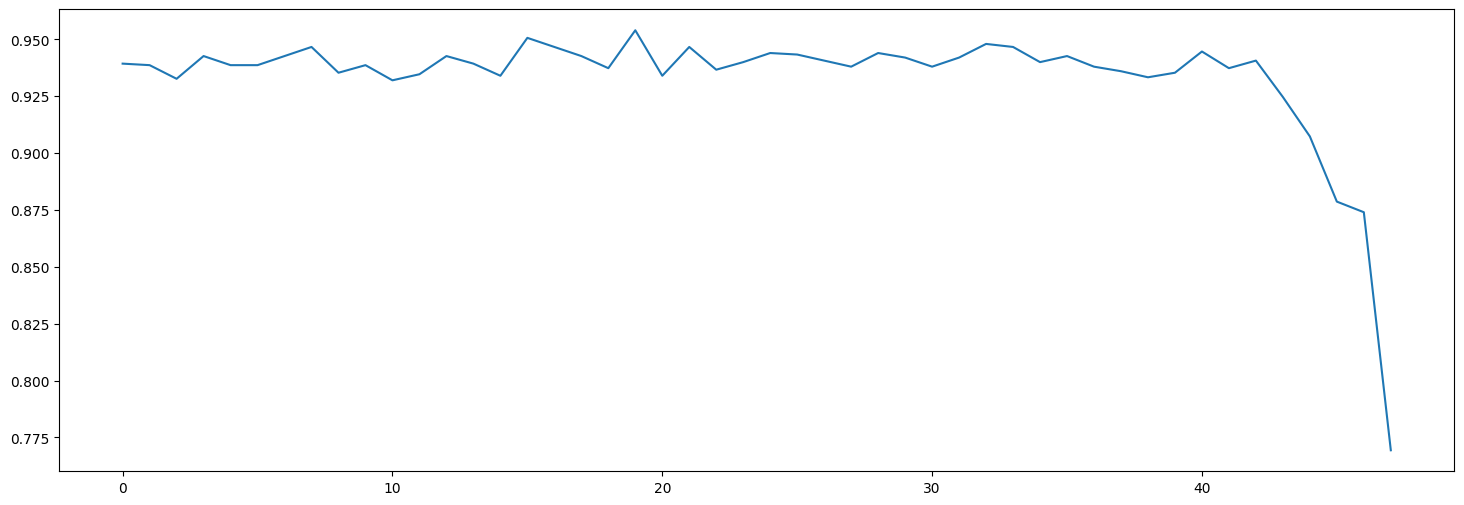

In [57]:
plt.plot(means)
plt.show()

Vemos que no ha sido muy útil. El rendimiento sobre el conjunto de test sólo empieza a decaer cuando *min_samples_split* es muy alto. El valor por defecto es 2 y, en este caso, no merece la pena cambiarlo.


Podemos repetir este estudio con cualquier otro parámetro de manera individual. 

También podemos buscar los mejores valores para varios parámetros a la vez con [SearchGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Además, podemos medir el tiempo que tarda en hacer la búsqueda.

In [58]:
t_start = time.time()
parameters = {
    'criterion':['gini', 'entropy'],
    'max_depth':[None, 10],
    'max_features':['sqrt', 'log2'],
    'max_leaf_nodes':[None, 25, 50],
    'min_impurity_decrease':[0.0, 0.001, 0.01],
    'min_samples_leaf':[8, 10, 12, 14],
    'min_samples_split':[2, 4]
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=10, scoring='accuracy')

clf.fit(X_data, y_data)

print('Se ha tardado {:.2f}s'.format(time.time() - t_start))
print('Mejores hiperparámetros encontrados:', clf.best_params_)

Se ha tardado 7.16s
Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}


Creamos el árbol con esos mejores parámetros. Sólo cambiamos los valores distintos a los que vienen por defecto.

In [59]:
final_tree = DecisionTreeClassifier(max_features= 'sqrt', min_samples_leaf= 8,random_state=843)
final_tree.fit(X_data,y_data)

DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=8,
                       random_state=843)

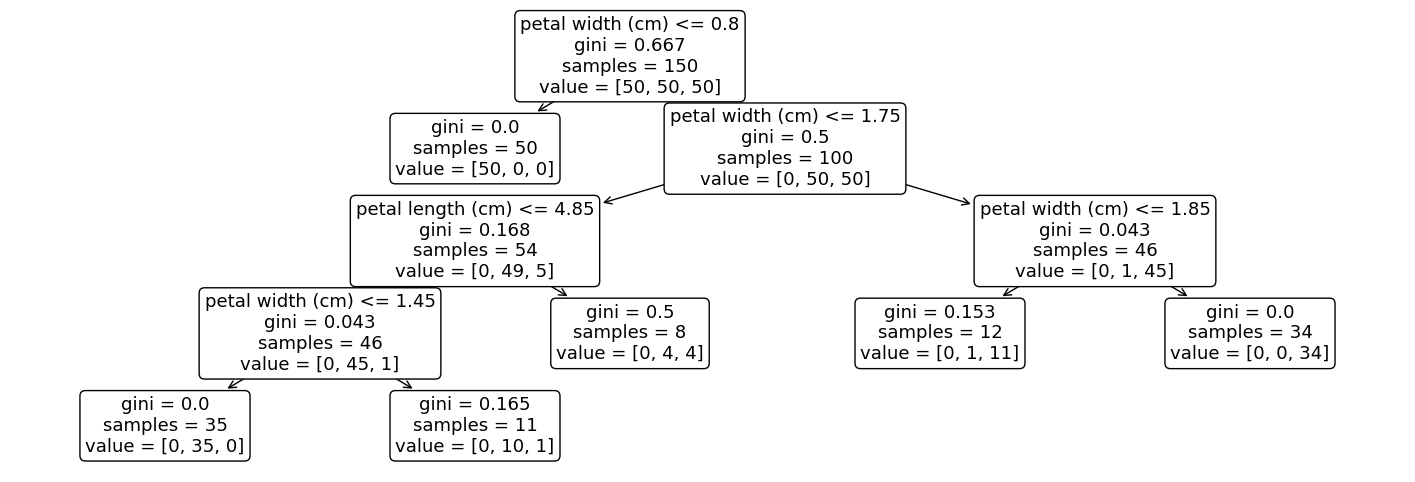

In [60]:
plot_tree(final_tree,rounded=True,feature_names=iris_dataset.feature_names)
plt.show()

In [61]:
print('### Matrices de confusión ###\n')
print('Entrenamiento:')
print(skm.confusion_matrix(y_train, final_tree.predict(X_train)))
print('\nPruebas:')
print(skm.confusion_matrix(y_test, final_tree.predict(X_test)))

### Matrices de confusión ###

Entrenamiento:
[[38  0  0]
 [ 0 36  1]
 [ 0  3 34]]

Pruebas:
[[12  0  0]
 [ 0 13  0]
 [ 0  2 11]]


Veamos las medidas de rendimiento

In [62]:
print("Rendimiento en el conjunto de entrenamiento: ",final_tree.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",final_tree.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",final_tree.score(X_data,y_data))

Rendimiento en el conjunto de entrenamiento:  0.9642857142857143
Rendimiento en el conjunto de prueba:  0.9473684210526315
Rendimiento en el conjunto total:  0.96


Se puede observar que la medida de rendimiento de este árbol no es 1 sobre el conjunto de entrenamiento, pero sobre el conjunto de test es muy buena.